# Figure 2

In [1]:
using DifferentialEquations
using LabelledArrays
using Parameters
using MitochondrialDynamics
import MitochondrialDynamics.Utils: second, μM, mV, mM, Hz
import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 14
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"

"sans-serif"

In [2]:
glc = range(3.0mM, 30.0mM, length=101)  # Range of glucose
tend = 3000.0  # Time span
u0 = LVector(g3p = 2.8μM,
             pyr = 8.5μM,
             nadh_c = 1μM,
             nadh_m = 60μM,
             atp_c = 4000μM,
             adp_c = 500μM,
             ca_m = 0.250μM,
             dpsi = 100mV,
             x2=0.25,
             x3=0.05)

param0 = MitoDynNode()

MitoDynNode{Float64}
  K_FISS: Float64 0.0016666666666666668
  K_FUSE: Float64 0.0016666666666666668
  R_FUSE23: Float64 0.5
  R_FISS23: Float64 1.5
  k_nadhc: Float64 0.1
  k_atp: Float64 0.04
  k_atp_ca: Float64 90.0
  k_g3p: Float64 0.01
  k_pyr: Float64 0.01
  Σa_c: Float64 4.5
  Σn_c: Float64 2.0
  gk: MitochondrialDynamics.GK{Float64}
  gpd: MitochondrialDynamics.GPD{Float64}
  ldh: MitochondrialDynamics.LDH{Float64}
  cai: MitochondrialDynamics.CaATP{Float64, Int64}
  adk: MitochondrialDynamics.AdK{Float64}
  k_nadhm: Float64 0.1
  Σn_m: Float64 2.2
  f1fo: MitochondrialDynamics.F1Fo{Float64}
  etc: MitochondrialDynamics.ETC{Float64}
  hleak: MitochondrialDynamics.HLeakExp{Float64}
  pdh: MitochondrialDynamics.PDH{Float64}
  nadht: MitochondrialDynamics.NADHT{Float64}
  mcu: MitochondrialDynamics.MCU{Float64}
  nclx: MitochondrialDynamics.NCLX{Float64}


In [3]:
sols = map(glc) do g
    param = setglc(param0, g)
    prob = SteadyStateProblem(model!, u0, param)
    sol = solve(prob, DynamicSS(Rodas5(), tspan=tend))
end

101-element Vector{SciMLBase.NonlinearSolution{Float64, 1, LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}, LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}, SteadyStateProblem{LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}, true, MitoDynNode{Float64}, ODEFunction{true, typeof(model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, DynamicSS{Rodas5{0, true, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Float64, Float64, Float64}, Nothing, Nothing}}:
 [0.001297771428592952, 0.0022434182647704448, 0.0003277239087309967, 0.02591261485836564, 1.5574639948248719, 1.53466959961947

In [4]:
"Plot figure 2"
function plot_fig2(sols, glc; size=(20,15),
                   glucoseScale = 5mM,
                   xlabelfontsize=16)

    # Collect data

    g3p = map(s->s.u.g3p, sols)
    pyr = map(s->s.u.pyr, sols)
    nadh_c = map(s->s.u.nadh_c, sols)
    nadh_m = map(s->s.u.nadh_m, sols)
    atp_c = map(s->s.u.atp_c, sols)
    adp_c = map(s->s.u.adp_c, sols)
    amp_c = ampcyto.(adp_c, atp_c, Ref(param0))
    ca_m = map(s->s.u.ca_m, sols)
    dpsi = map(s->s.u.dpsi, sols)
    ca_c  = cacyto.(adp_c, atp_c, Ref(param0), 0.0)
    x2 = map(s->s.u.x2, sols)
    x3 = map(s->s.u.x3, sols)
    x1 = getx1.(x2, x3)
    degree = avgdeg.(x2, x3, x1)

    for x in (g3p, pyr, nadh_c, nadh_m, atp_c, adp_c, amp_c, ca_m, dpsi, ca_c)
        x .*= 1000
    end


    # Plot
    glc5 = glc ./ glucoseScale

    fig, ax = plt.subplots(3, 3, figsize=size)

    ax[1, 1].plot(glc5, g3p)
    ax[1, 1].set(title="(A) G3P (μM)", ylim=(0.0, 10.0))

    ax[1, 2].plot(glc5, pyr)
    ax[1, 2].set(title="(B) Pyruvate (μM)", ylim=(0.0, 125.0))

    ax[1, 3].plot(glc5, ca_c, label="cyto")
    ax[1, 3].plot(glc5, ca_m, label="mito")
    ax[1, 3].set(ylim=(0.0, 1.5), title="(C) Calcium (μM)")
    ax[1, 3].legend(loc="right")

    ax[2, 1].plot(glc5, nadh_c, label="cyto")
    ax[2, 1].plot(glc5, nadh_m, label="mito")
    ax[2, 1].set(title="(D) NADH (μM)")
    ax[2, 1].legend(loc="right")

    ax[2, 2].plot(glc5, atp_c, label="ATP")
    ax[2, 2].plot(glc5, adp_c, label="ADP")
    ax[2, 2].plot(glc5, amp_c, label="AMP")
    ax[2, 2].set(title="(E) Adenylates (μM)")
    ax[2, 2].legend(loc="right")

    ax[2, 3].plot(glc5, atp_c ./ adp_c)
    ax[2, 3].set(title="(F) ATP/ADP ratio" , ylim=(0.0, 45.0))

    ax[3, 1].plot(glc5, dpsi)
    ax[3, 1].set(title="(G) ΔΨ (mV)", ylim=(80, 160))
    ax[3, 1].set_xlabel("Glucose (X)", fontsize=xlabelfontsize)
    # ax[3, 1].legend(loc="best")

    ax[3, 2].plot(glc5, x1, label="X1")
    ax[3, 2].plot(glc5, x2, label="X2")
    ax[3, 2].plot(glc5, x3, label="X3")
    ax[3, 2].set_title("(H) Mitochondrial nodes")
    ax[3, 2].set_xlabel("Glucose (X)", fontsize=xlabelfontsize)
    ax[3, 2].legend()

    ax[3, 3].plot(glc5, degree)
    ax[3, 3].set_title("(I) Average Node Degree")
    ax[3, 3].set_xlabel("Glucose (X)", fontsize=xlabelfontsize)

    plt.tight_layout()
    return fig
end

plot_fig2

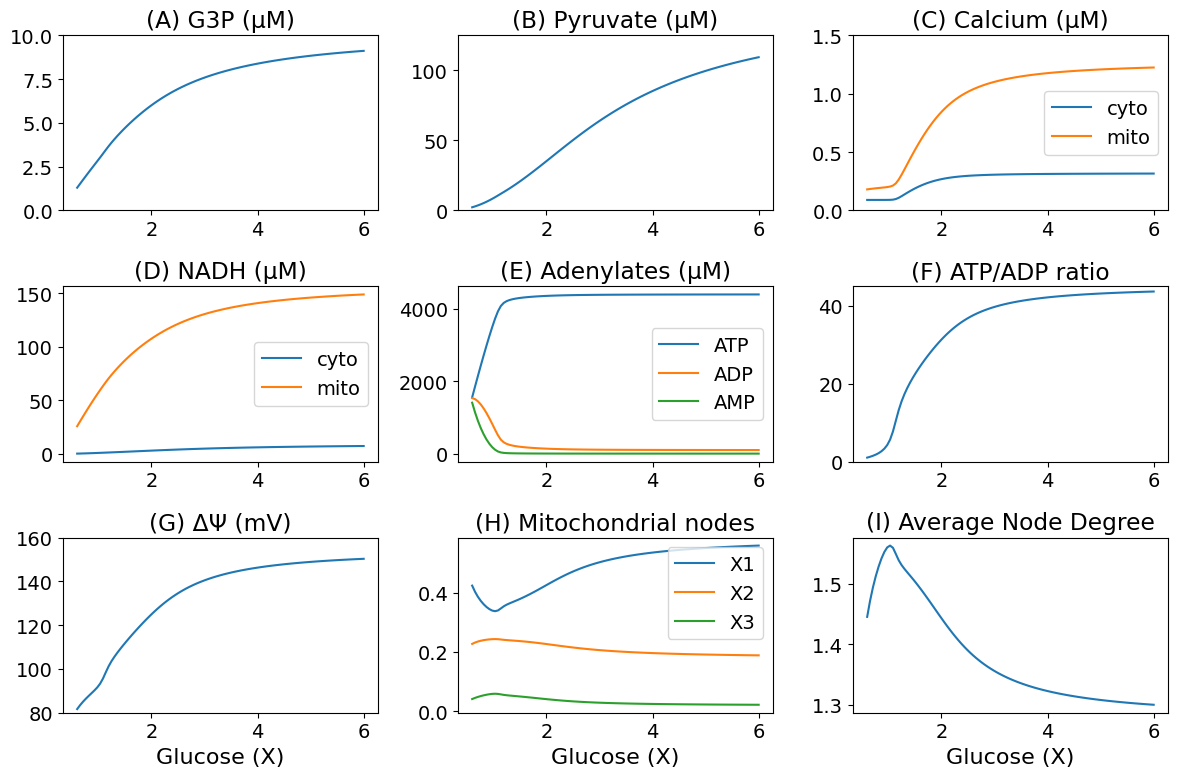

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /builds/NTUMito/wen-wei-tseng/MitochondrialDynamics/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


In [5]:
fig2 = plot_fig2(sols, glc, size=(12, 8));

In [6]:
# Uncomment if pdf file is required
# fig2.savefig("Fig2.pdf")